In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [36]:
data = pd.read_csv('insurance.csv')
orig_data =  pd.read_csv('insurance.csv')

In [37]:
orig_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [44]:
print(str('Is there any NaN value in the dataset: '), data.isnull().values.any())

Is there any NaN value in the dataset:  False


In [45]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [46]:


def is_outlier_iqr(data,key):
    q3, q1 = np.percentile(data[key], [75 ,25])
    iqr = q3-q1
    max_iqr = (1.5*iqr) + q3
    min_iqr = (1.5*iqr) - q1 
    count_max_iqr_el = data[key].loc[data[key] > max_iqr ].count()
    count_min_iqr_el = data[key].loc[data[key] < min_iqr ].count()
    return {'upper_end' : count_max_iqr_el, 'lower-end' : count_min_iqr_el}

outlier_data_for_age = is_outlier_iqr(data,'age')
outlier_data_for_bmi = is_outlier_iqr(data,'bmi')
outlier_data_for_charges = is_outlier_iqr(data,'charges')
outlier_data_for_charges

{'upper_end': 139, 'lower-end': 908}

## Primary Data Anyalysis
1. Age :
    - No major outliers as per iqr
    - Data is available for ages between 18-64 No kids or old age people are included
2. bmi :
    - 9 people are upper end outliers
    -BMI ranges
        For most adults, an ideal BMI is in the 18.5 to 24.9 range.

        If your BMI is:

        below 18.5 – you're in the underweight range
        between 18.5 and 24.9 – you're in the healthy weight range
        between 25 and 29.9 – you're in the overweight range
        between 30 and 39.9 – you're in the obese range
      Accordint to this about 25% people are obese
3. charges : 
    - lot of outliers, we will analyter this more later on

In [47]:
from sklearn.preprocessing import LabelEncoder
#sex
le = LabelEncoder()
le.fit(data.sex.drop_duplicates()) 
data.sex = le.transform(data.sex)
# smoker or not
le.fit(data.smoker.drop_duplicates()) 
data.smoker = le.transform(data.smoker)
#region
le.fit(data.region.drop_duplicates()) 
data.region = le.transform(data.region)

In [48]:
data

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10600.54830
1334,18,0,31.920,0,0,0,2205.98080
1335,18,0,36.850,0,0,2,1629.83350
1336,21,0,25.800,0,0,3,2007.94500


In [49]:
data.corr()['charges'].sort_values()

region     -0.006208
sex         0.057292
children    0.067998
bmi         0.198341
age         0.299008
smoker      0.787251
charges     1.000000
Name: charges, dtype: float64

/var/folders/q_/fpd846tn7sj3hfc3bp6q8jf00000gn/T/ipykernel_5301/3611801594.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True),


<AxesSubplot:>

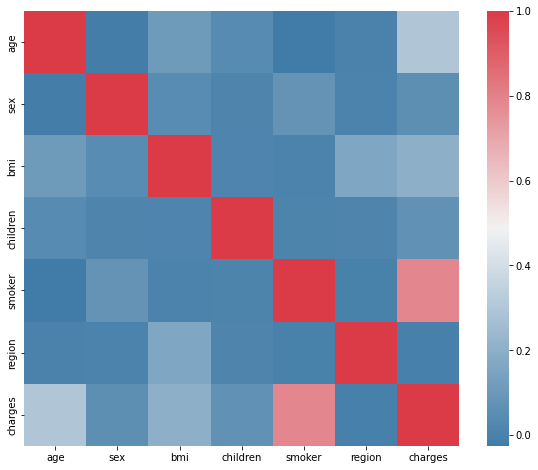

In [50]:
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True),
            square=True, ax=ax)


## Correlation
A strong correlation is observed only with the fact of smoking the patient. 

/Users/ashutoshparab/chatbot_demo/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ashutoshparab/chatbot_demo/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of charges for non-smokers')

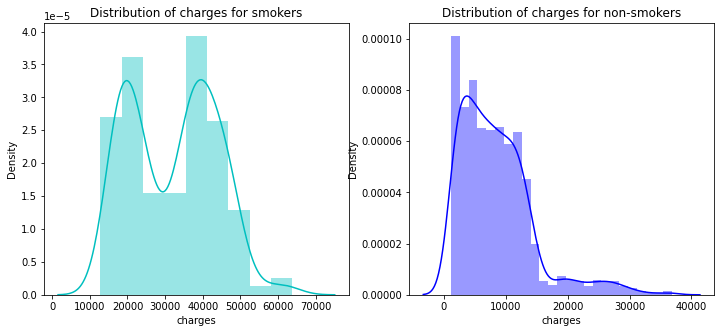

In [52]:
f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(data[(data.smoker == 1)]["charges"],color='c',ax=ax)
ax.set_title('Distribution of charges for smokers')

ax=f.add_subplot(122)
sns.distplot(data[(data.smoker == 0)]['charges'],color='b',ax=ax)
ax.set_title('Distribution of charges for non-smokers')

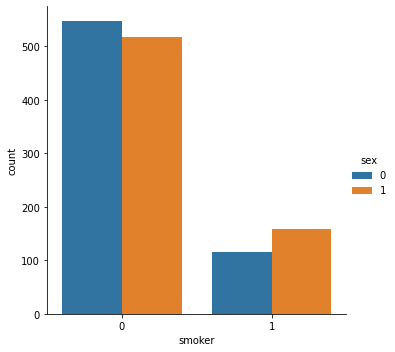

In [64]:
ax = sns.catplot(x='smoker',hue='sex',kind="count", data=data)

-- 1 -> smoker
---0 -> non-smoker

In [58]:
data.loc[data.smoker == 0].charges.mean()

8434.268297856204

In [59]:
data.loc[data.smoker == 1].charges.mean()

32050.23183153284

## Comments on Dsitrubution of charges
 -- On average Smoking patients spend more on treatment. But the number of non-smoking patients is greater.

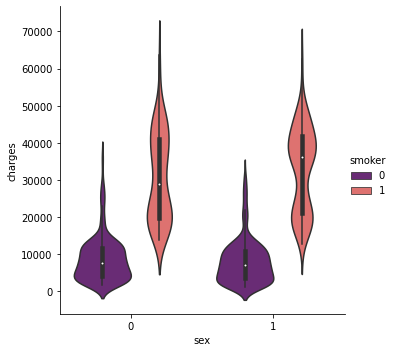

In [65]:
sns.catplot(x="sex", y="charges", hue="smoker",
            kind="violin", data=data, palette = 'magma')

<AxesSubplot:title={'center':'Box plot for charges of women'}, xlabel='charges', ylabel='smoker'>

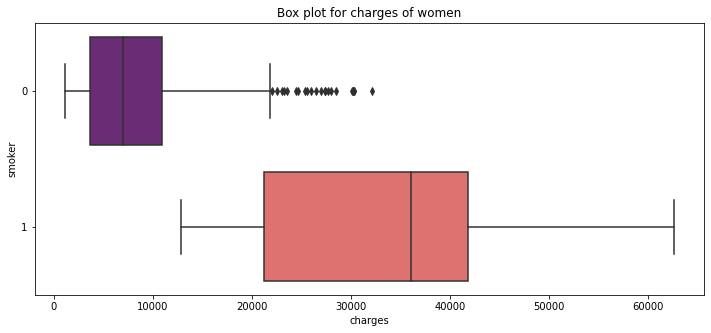

In [67]:
plt.figure(figsize=(12,5))
plt.title("Box plot for charges of women")
sns.boxplot(y="smoker", x="charges", data =  data[(data.sex == 1)] , orient="h", palette = 'magma')


<AxesSubplot:title={'center':'Box plot for charges of men'}, xlabel='charges', ylabel='smoker'>

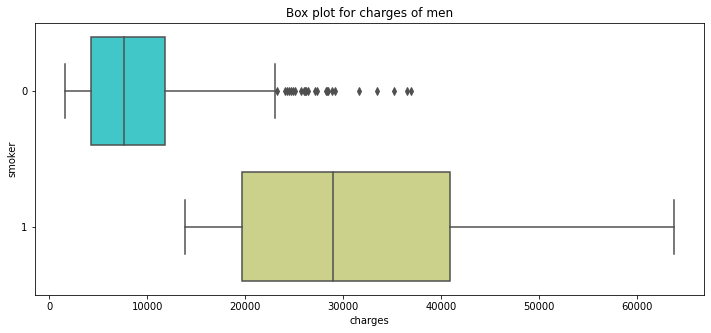

In [69]:
plt.figure(figsize=(12,5))
plt.title("Box plot for charges of men")
sns.boxplot(y="smoker", x="charges", data =  data[(data.sex == 0)] , orient="h", palette = 'rainbow')

-- Now let's pay attention to the age of the patients. First, let's look at how age affects the cost of treatment, and also look at patients of what age more in our data set.

/Users/ashutoshparab/chatbot_demo/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


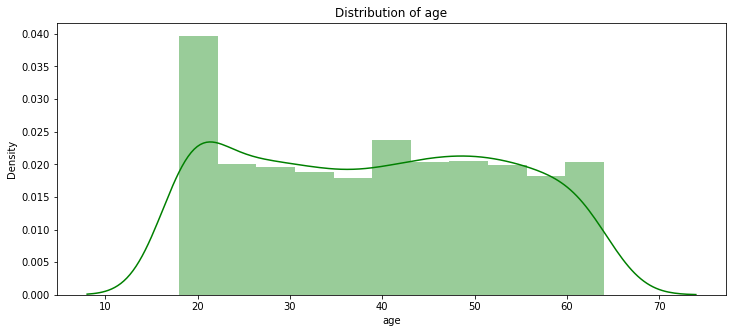

In [70]:
plt.figure(figsize=(12,5))
plt.title("Distribution of age")
ax = sns.distplot(data["age"], color = 'g')

Text(0.5, 1.0, 'The number of smokers and non-smokers (18 years old)')

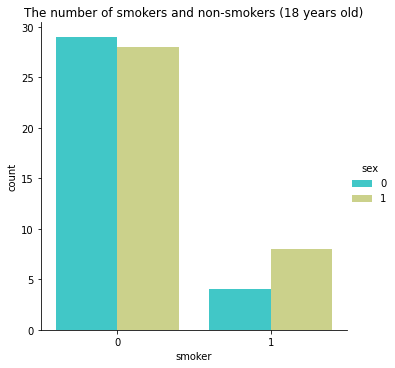

In [72]:
sns.catplot(x="smoker", kind="count",hue = 'sex', palette="rainbow", data=data[(data.age == 18)])
plt.title("The number of smokers and non-smokers (18 years old)")

<AxesSubplot:title={'center':'Box plot for charges 18 years old smokers'}, xlabel='charges', ylabel='smoker'>

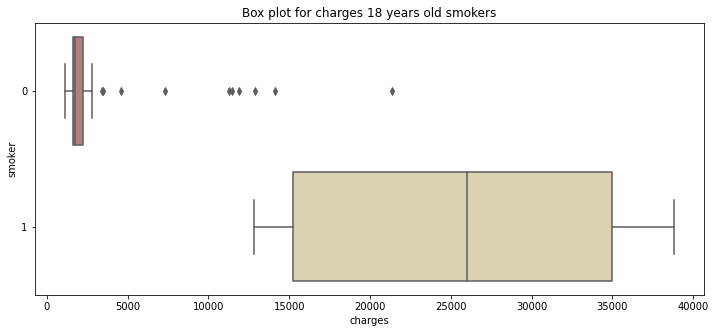

In [74]:
plt.figure(figsize=(12,5))
plt.title("Box plot for charges 18 years old smokers")
sns.boxplot(y="smoker", x="charges", data = data[(data.age == 18)] , orient="h", palette = 'pink')

![image.png](attachment:image.png)
Oh. As we can see, even at the age of 18 smokers spend much more on treatment than non-smokers. Among non-smokers we are seeing some " tails." I can assume that this is due to serious diseases or accidents. Now let's see how the cost of treatment depends on the age of smokers and non-smokers patients.

Text(0.5, 1.0, 'Distribution of charges and age for non-smokers')

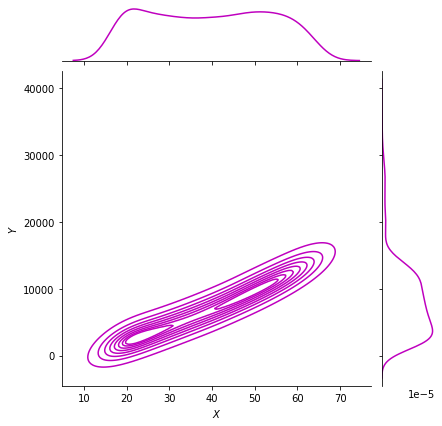

In [77]:
g = sns.jointplot(x="age", y="charges", data = data[(data.smoker == 0)],kind="kde", color="m")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
ax.set_title('Distribution of charges and age for non-smokers')

Text(0.5, 1.0, 'Distribution of charges and age for smokers')

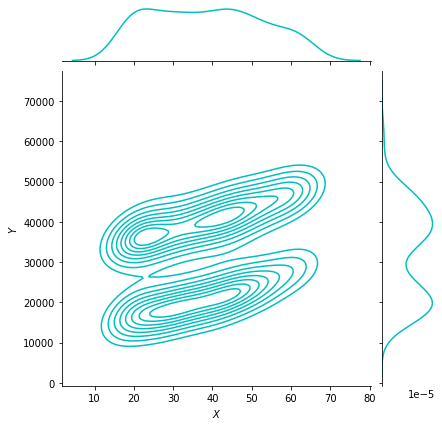

In [79]:
g = sns.jointplot(x="age", y="charges", data = data[(data.smoker == 1)],kind="kde", color="c")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
ax.set_title('Distribution of charges and age for smokers')


In [80]:
#non - smokers
p = figure(plot_width=500, plot_height=450)
p.circle(x=data[(data.smoker == 0)].age,y=data[(data.smoker == 0)].charges, size=7, line_color="navy", fill_color="pink", fill_alpha=0.9)

show(p)

In [81]:
#smokers
p = figure(plot_width=500, plot_height=450)
p.circle(x=data[(data.smoker == 1)].age,y=data[(data.smoker == 1)].charges, size=7, line_color="navy", fill_color="red", fill_alpha=0.9)
show(p)

/Users/ashutoshparab/chatbot_demo/lib/python3.8/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Smokers and non-smokers')

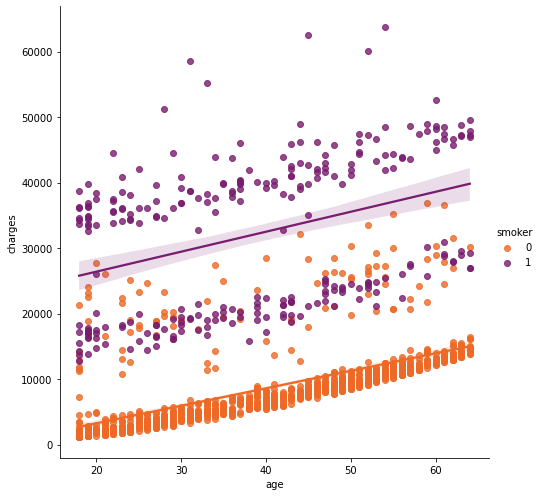

In [82]:
sns.lmplot(x="age", y="charges", hue="smoker", data=data, palette = 'inferno_r', size = 7)
ax.set_title('Smokers and non-smokers')

In non-smokers, the cost of treatment increases with age. That makes sense. So take care of your health, friends! In smoking people, we do not see such dependence. I think that it is not only in smoking but also in the peculiarities of the dataset. Such a strong effect of Smoking on the cost of treatment would be more logical to judge having a set of data with a large number of records and signs. But we work with what we have! Let's pay attention to bmi. I am surprised that this figure but affects the cost of treatment in patients. Or are we on a diet for nothing?

/Users/ashutoshparab/chatbot_demo/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


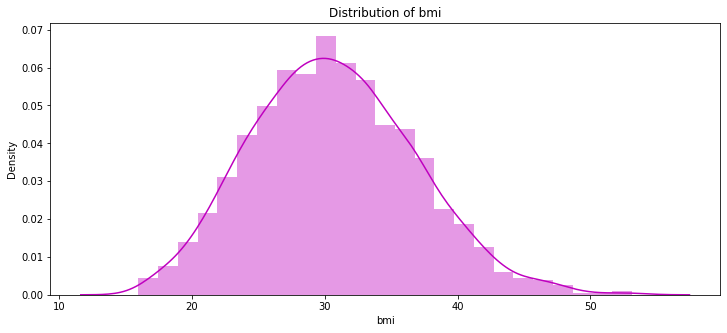

In [84]:
plt.figure(figsize=(12,5))
plt.title("Distribution of bmi")
ax = sns.distplot(data["bmi"], color = 'm')

There's something insanely beautiful about this distribution, isn't there?
The average BMI in patients is 30. I think I should go to the great Google with a question about this indicator.![image.png](attachment:image.png)With a value equal to 30 starts obesity. I also calculated my BMI and now I can safely eat a sandwich. Let's start to explore! First, let's look at the distribution of costs in patients with BMI greater than 30 and less than 30.

/Users/ashutoshparab/chatbot_demo/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


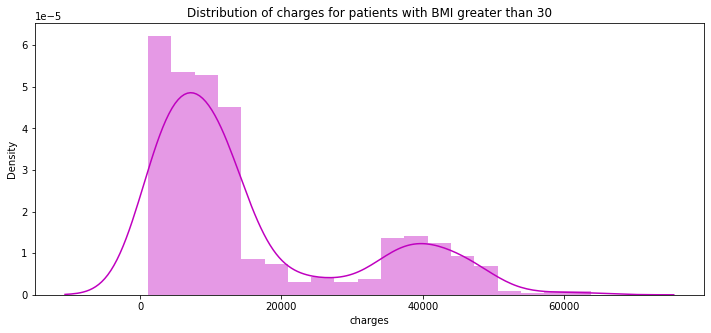

In [86]:
plt.figure(figsize=(12,5))
plt.title("Distribution of charges for patients with BMI greater than 30")
ax = sns.distplot(data[(data.bmi >= 30)]['charges'], color = 'm')

/Users/ashutoshparab/chatbot_demo/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


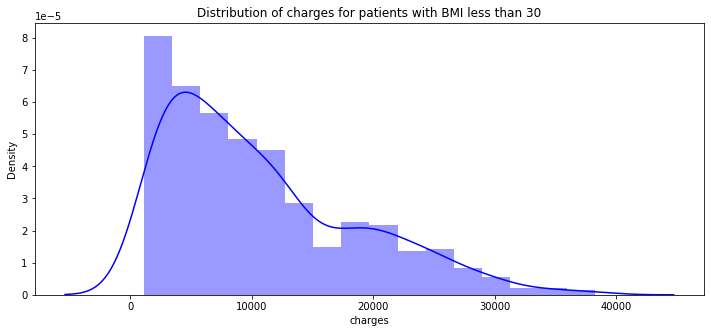

In [87]:
plt.figure(figsize=(12,5))
plt.title("Distribution of charges for patients with BMI less than 30")
ax = sns.distplot(data[(data.bmi < 30)]['charges'], color = 'b')

Patients with BMI above 30 spend more on treatment!

Text(0.5, 1.0, 'Distribution of bmi and charges')

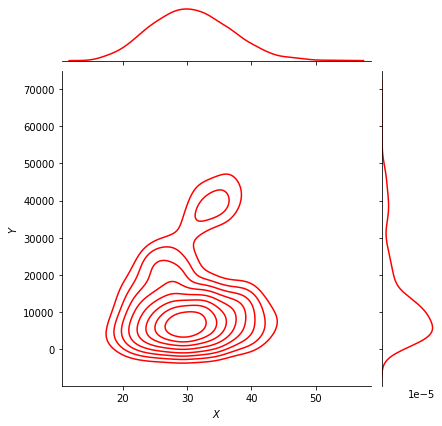

In [89]:
g = sns.jointplot(x="bmi", y="charges", data = data,kind="kde", color="r")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
ax.set_title('Distribution of bmi and charges')

/Users/ashutoshparab/chatbot_demo/lib/python3.8/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


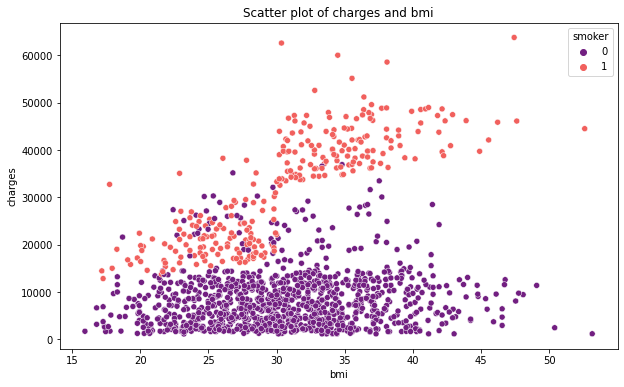

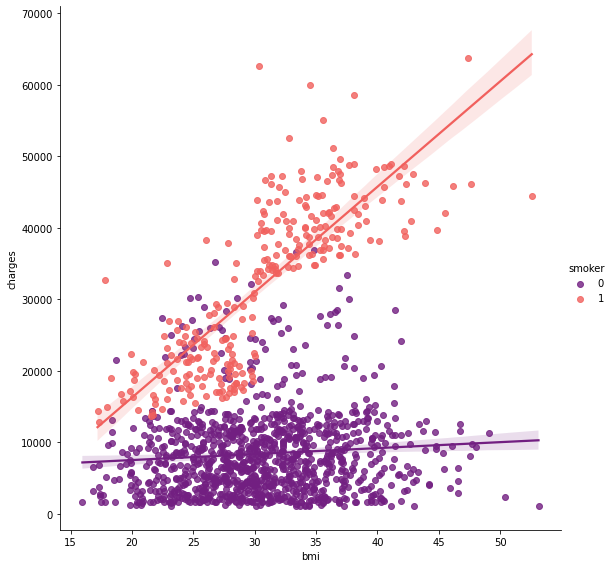

In [90]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='bmi',y='charges',data=data,palette='magma',hue='smoker')
ax.set_title('Scatter plot of charges and bmi')

sns.lmplot(x="bmi", y="charges", hue="smoker", data=data, palette = 'magma', size = 8)

Let's pay attention to children. First, let's see how many children our patients have.

/Users/ashutoshparab/chatbot_demo/lib/python3.8/site-packages/seaborn/categorical.py:3750: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


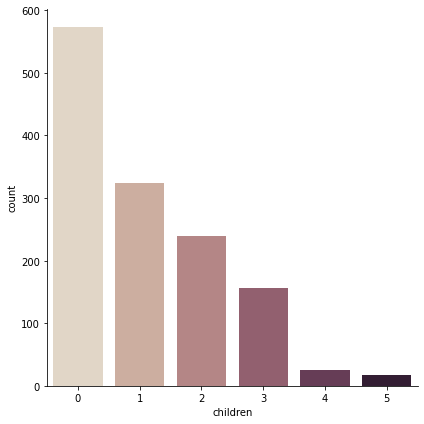

In [91]:
sns.catplot(x="children", kind="count", palette="ch:.25", data=data, size = 6)

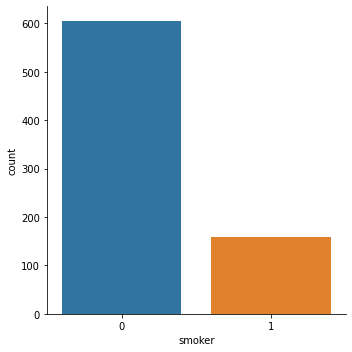

In [96]:
sns.catplot(x='smoker',kind='count', data=data[(data.children > 0)])

I have a few more ideas for exploring this dataset. I will soon implement them. And now we are going to predict the cost of treatment. Let's start with the usual linear regression.

In [97]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [98]:
x = data.drop(['charges'],axis=1)
y = data['charges']

In [102]:
x_train,x_test,y_train,y_test =  train_test_split(x,y, random_state = 0)
lr = LinearRegression().fit(x_train,y_train)

In [104]:
y_train_pred = lr.predict(x_train)
y_test_pred =  lr.predict(x_test)

In [105]:
print(lr.score(x_test,y_test))

0.7962732059725786


 Now let's add polynomial signs. And look at the result.

In [106]:
X = data.drop(['charges','region'], axis = 1)
Y = data.charges



quad = PolynomialFeatures (degree = 2)
x_quad = quad.fit_transform(X)

X_train,X_test,Y_train,Y_test = train_test_split(x_quad,Y, random_state = 0)

plr = LinearRegression().fit(X_train,Y_train)

Y_train_pred = plr.predict(X_train)
Y_test_pred = plr.predict(X_test)

print(plr.score(X_test,Y_test))

0.8849197344147234


And finally try RandomForestRegressor. I've never used this algorithm in regression analysis.

In [107]:
forest = RandomForestRegressor(n_estimators = 100,
                              criterion = 'mse',
                              random_state = 1,
                              n_jobs = -1)

In [108]:
forest.fit(x_train,y_train)
forest_train_pred = forest.predict(x_train)
forest_test_pred = forest.predict(x_test)


/Users/ashutoshparab/chatbot_demo/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


In [109]:
print('MSE train data: %.3f, MSE test data: %.3f' % (
mean_squared_error(y_train,forest_train_pred),
mean_squared_error(y_test,forest_test_pred)))
print('R2 train data: %.3f, R2 test data: %.3f' % (
r2_score(y_train,forest_train_pred),
r2_score(y_test,forest_test_pred)))

MSE train data: 3746684.434, MSE test data: 19965476.411
R2 train data: 0.974, R2 test data: 0.873


## plot cost function

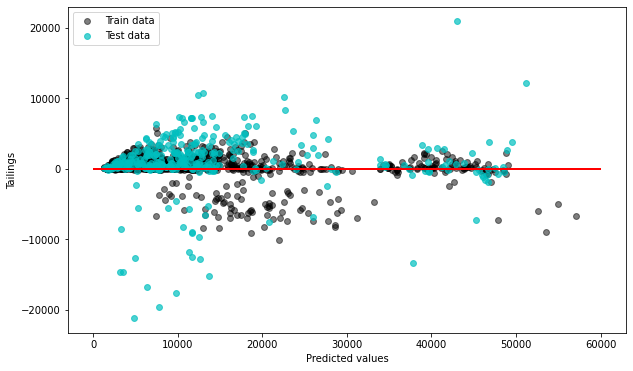

In [110]:
plt.figure(figsize=(10,6))

plt.scatter(forest_train_pred,forest_train_pred - y_train,
          c = 'black', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
plt.scatter(forest_test_pred,forest_test_pred - y_test,
          c = 'c', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Tailings')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = 0, xmax = 60000, lw = 2, color = 'red')
plt.show()

Good result. But we see a noticeable retraining of the algorithm on the training data.